In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors
%matplotlib inline

Using Theano backend.


In [2]:
### SET UP FOR SIMULATION CODE ###

# n(z)
#pz_fid = pickle.load(open('pz_euclid.pkl', 'rb'))
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz_fid, modes, N, nl]

# Fiducial power spectrum
C = power_spectrum(theta_fiducial, sim_args)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = power_spectrum(theta_plus, [pz_fid, modes, np.zeros((nz, nz))])
    Cm = power_spectrum(theta_minus, [pz_fid, modes, np.zeros((nz, nz))])
    C0 = power_spectrum(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz))])

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

# Projection arguments
projection_args = [Finv, 0, theta_fiducial, fisher_errors, prior_mean, Qinv, Cinv, dCdt, modes, nl]

# SimABC args
simABC_args = [sim_args, projection_args, prior_args]

In [3]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: simulationABC(x, simABC_args)

In [4]:
# The data vector: import or otherwise simulate for testing
data = projected_score(power_spectrum(theta_fiducial, sim_args), projection_args)


In [5]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [6]:
# Create the DELFI MDN object
n_components = 1

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 51s 1ms/step - loss: 64.2035 - val_loss: 57.7589
Epoch 2/50
45000/45000 [==============================] - 54s 1ms/step - loss: 51.4969 - val_loss: 17.7055
Epoch 3/50
45000/45000 [==============================] - 51s 1ms/step - loss: 16.5195 - val_loss: 16.3472
Epoch 4/50
45000/45000 [==============================] - 51s 1ms/step - loss: 15.6685 - val_loss: 14.9615
Epoch 5/50
45000/45000 [==============================] - 51s 1ms/step - loss: 14.7996 - val_loss: 14.0041
Epoch 6/50
45000/45000 [==============================] - 51s 1ms/step - loss: 13.8198 - val_loss: 13.1217
Epoch 7/50
45000/45000 [==============================] - 50s 1ms/step - loss: 12.7646 - val_loss: 12.3048
Epoch 8/50
45000/45000 [==============================] - 52s 1ms/step - loss: 11.6385 - val_loss: 11.4972
Epoch 9/50
45000/45000 [==============================] - 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


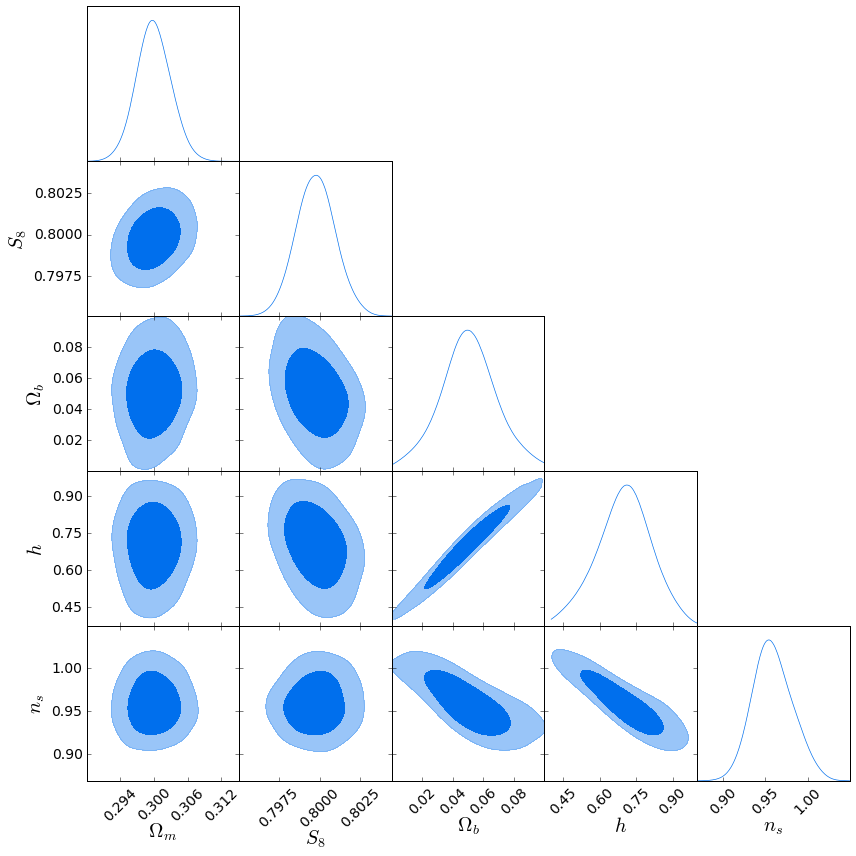

In [7]:
# Proposal for the Fisher pre-training stage
proposal = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Do the Fisher pre-training
mdn.fisher_pretraining(50000, proposal, epochs=50)

Running initial 500 sims...
Done.
Train on 450 samples, validate on 50 samples
Epoch 1/100
450/450 [==============================] - 0s 626us/step - loss: 23.2344 - val_loss: 15.9941
Epoch 2/100
450/450 [==============================] - 0s 639us/step - loss: 17.7521 - val_loss: 11.7208
Epoch 3/100
450/450 [==============================] - 0s 641us/step - loss: 11.7310 - val_loss: 9.2414
Epoch 4/100
450/450 [==============================] - 0s 633us/step - loss: 9.1559 - val_loss: 10.3958
Epoch 5/100
450/450 [==============================] - 0s 624us/step - loss: 8.9814 - val_loss: 6.3645
Epoch 6/100
450/450 [==============================] - 0s 631us/step - loss: 7.4092 - val_loss: 6.5440
Epoch 7/100
450/450 [==============================] - 0s 641us/step - loss: 6.9020 - val_loss: 5.8862
Epoch 8/100
450/450 [==============================] - 0s 654us/step - loss: 6.4727 - val_loss: 6.1033
Epoch 9/100
450/450 [==============================] - 0s 635us/step - loss: 6.1526 - val_l

450/450 [==============================] - 0s 630us/step - loss: 4.7424 - val_loss: 4.7014
Epoch 80/100
450/450 [==============================] - 0s 610us/step - loss: 4.7581 - val_loss: 4.7533
Epoch 81/100
450/450 [==============================] - 0s 618us/step - loss: 4.7474 - val_loss: 4.7097
Epoch 82/100
450/450 [==============================] - 0s 627us/step - loss: 4.7106 - val_loss: 4.7273
Epoch 83/100
450/450 [==============================] - 0s 614us/step - loss: 4.7124 - val_loss: 4.6919
Epoch 84/100
450/450 [==============================] - 0s 632us/step - loss: 4.7153 - val_loss: 4.6959
Epoch 85/100
450/450 [==============================] - 0s 613us/step - loss: 4.6872 - val_loss: 4.7514
Epoch 86/100
450/450 [==============================] - 0s 611us/step - loss: 4.6950 - val_loss: 4.6815
Epoch 87/100
450/450 [==============================] - 0s 616us/step - loss: 4.6815 - val_loss: 4.6882
Epoch 88/100
450/450 [==============================] - 0s 609us/step - loss:

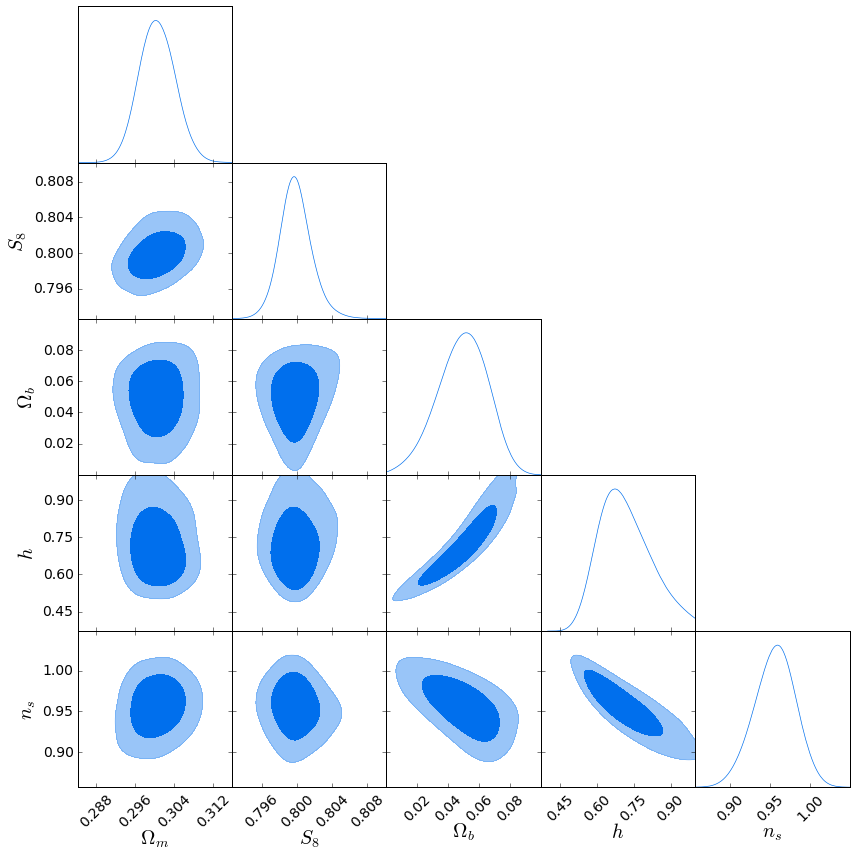

Population 1/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 598us/step - loss: 4.4245 - val_loss: 3.9819
Epoch 2/100
900/900 [==============================] - 1s 624us/step - loss: 4.3982 - val_loss: 3.8264
Epoch 3/100
900/900 [==============================] - 1s 615us/step - loss: 4.3945 - val_loss: 3.8336
Epoch 4/100
900/900 [==============================] - 1s 602us/step - loss: 4.4106 - val_loss: 3.8925
Epoch 5/100
900/900 [==============================] - 1s 602us/step - loss: 4.4258 - val_loss: 3.9103
Epoch 6/100
900/900 [==============================] - 1s 605us/step - loss: 4.3667 - val_loss: 3.8273
Epoch 7/100
900/900 [==============================] - 1s 606us/step - loss: 4.3893 - val_loss: 3.8540
Epoch 8/100
900/900 [==============================] - 1s 617us/step - loss: 4.3593 - val_loss: 3.8201
Epoch 9/100
900/900 [==============================] -

900/900 [==============================] - 1s 660us/step - loss: 4.1615 - val_loss: 3.7728
Epoch 79/100
900/900 [==============================] - 1s 985us/step - loss: 4.1963 - val_loss: 3.6474
Epoch 80/100
900/900 [==============================] - 1s 636us/step - loss: 4.2102 - val_loss: 3.7093
Epoch 81/100
900/900 [==============================] - 1s 602us/step - loss: 4.2093 - val_loss: 3.6360
Epoch 82/100
900/900 [==============================] - 1s 733us/step - loss: 4.2156 - val_loss: 3.7924
Epoch 83/100
900/900 [==============================] - 1s 652us/step - loss: 4.2009 - val_loss: 3.6503
Epoch 84/100
900/900 [==============================] - 1s 584us/step - loss: 4.1674 - val_loss: 3.7645
Epoch 85/100
900/900 [==============================] - 1s 578us/step - loss: 4.1689 - val_loss: 3.6386
Epoch 86/100
900/900 [==============================] - 1s 581us/step - loss: 4.1470 - val_loss: 3.6052
Epoch 87/100
900/900 [==============================] - 1s 576us/step - loss:

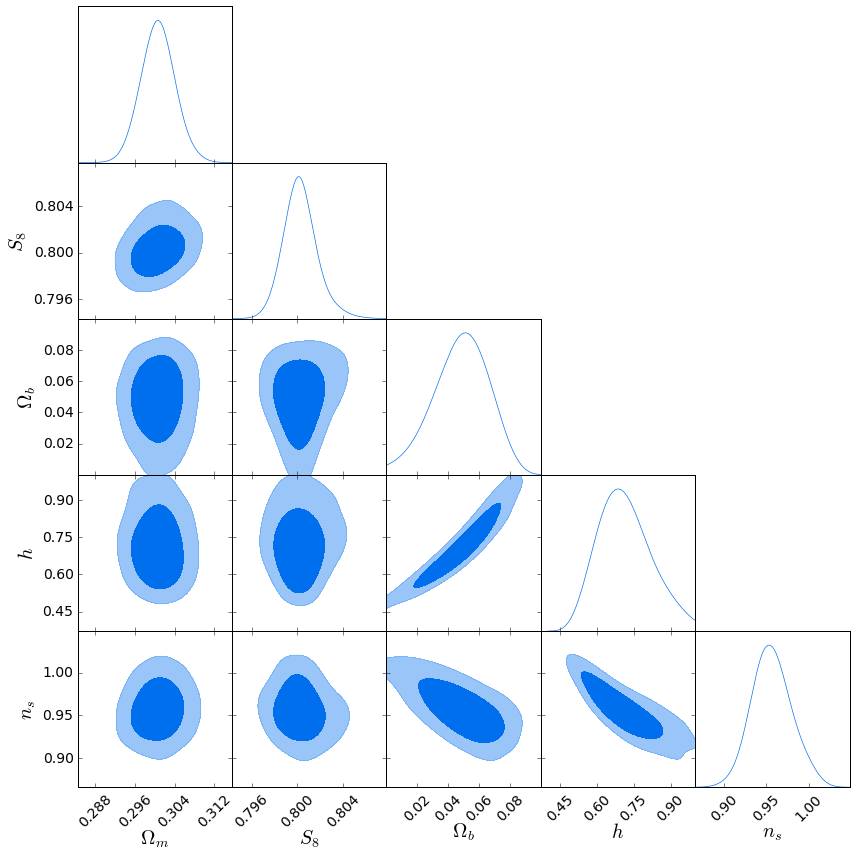

Population 2/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 1s 612us/step - loss: 3.9866 - val_loss: 4.2511
Epoch 2/100
1350/1350 [==============================] - 1s 603us/step - loss: 3.9823 - val_loss: 4.1488
Epoch 3/100
1350/1350 [==============================] - 1s 614us/step - loss: 4.0305 - val_loss: 4.2209
Epoch 4/100
1350/1350 [==============================] - 1s 684us/step - loss: 4.0491 - val_loss: 4.2793
Epoch 5/100
1350/1350 [==============================] - 1s 603us/step - loss: 3.9690 - val_loss: 4.1874
Epoch 6/100
1350/1350 [==============================] - 1s 871us/step - loss: 3.9706 - val_loss: 4.3004
Epoch 7/100
1350/1350 [==============================] - 1s 575us/step - loss: 4.0066 - val_loss: 4.2515
Epoch 8/100
1350/1350 [==============================] - 1s 567us/step - loss: 4.0132 - val_loss: 4.1784
Epoch 9/100
1350/1350 [==============

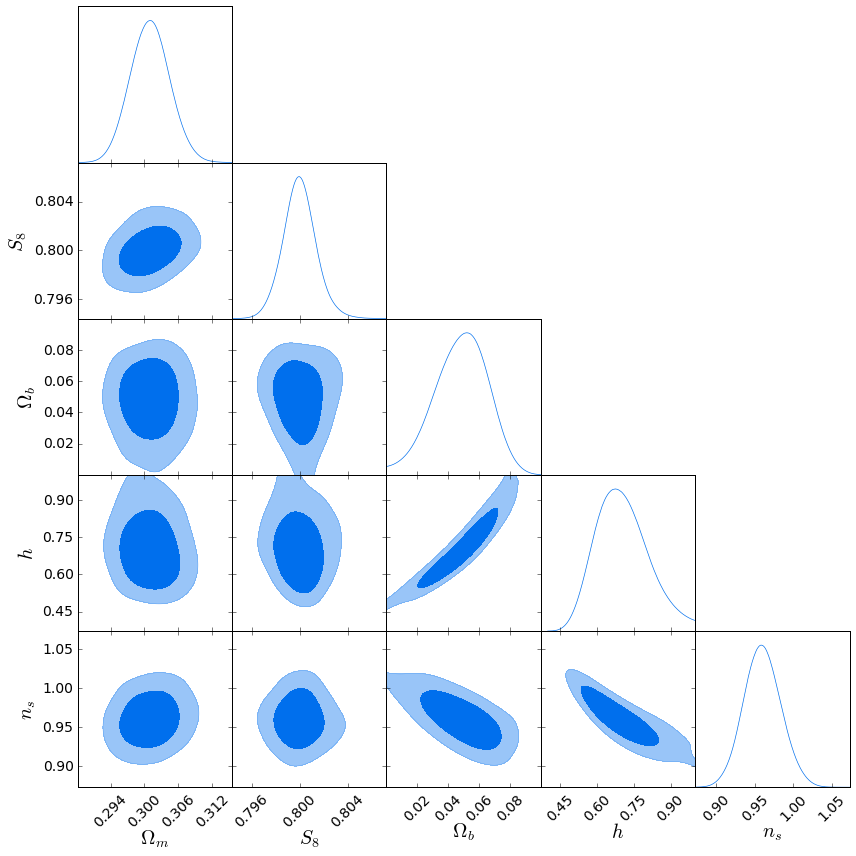

Population 3/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 1s 563us/step - loss: 3.9719 - val_loss: 4.2208
Epoch 2/100
1800/1800 [==============================] - 1s 565us/step - loss: 4.0388 - val_loss: 4.8695
Epoch 3/100
1800/1800 [==============================] - 1s 559us/step - loss: 4.0875 - val_loss: 4.3806
Epoch 4/100
1800/1800 [==============================] - 1s 557us/step - loss: 3.9745 - val_loss: 4.2079
Epoch 5/100
1800/1800 [==============================] - 1s 561us/step - loss: 3.9571 - val_loss: 4.1219
Epoch 6/100
1800/1800 [==============================] - 1s 566us/step - loss: 3.9447 - val_loss: 4.2042
Epoch 7/100
1800/1800 [==============================] - 1s 574us/step - loss: 3.9307 - val_loss: 4.1493
Epoch 8/100
1800/1800 [==============================] - 1s 675us/step - loss: 3.9152 - val_loss: 4.5576
Epoch 9/100
1800/1800 [==============

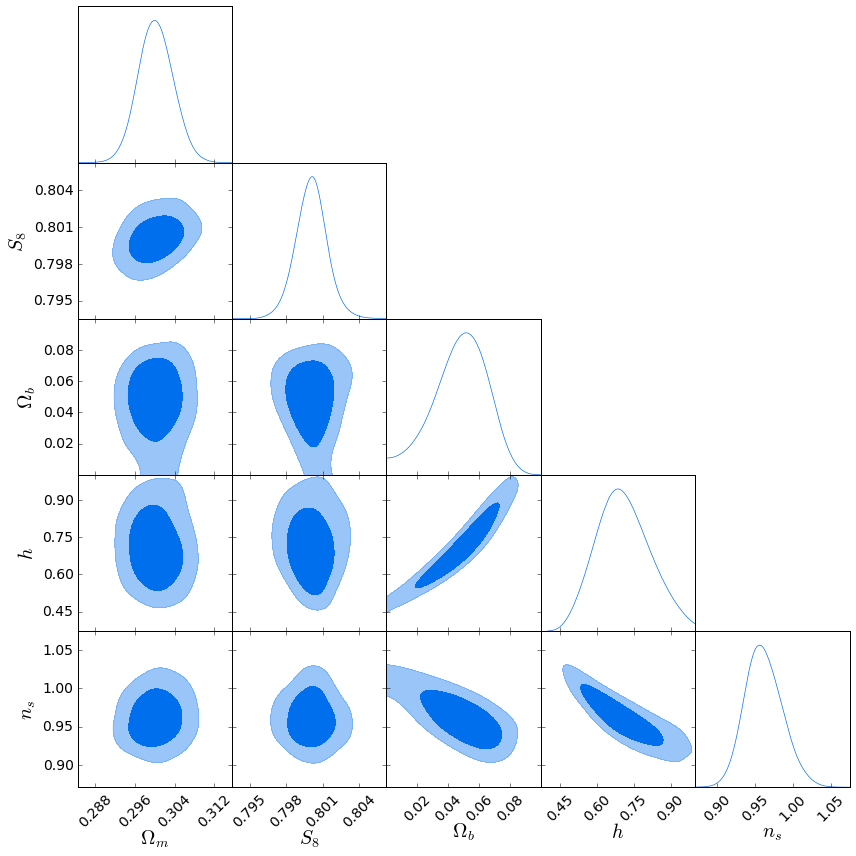

Population 4/8
Sampling proposal density...
Done.
Running 500 sims...
Done.
Train on 2250 samples, validate on 250 samples
Epoch 1/100
1800/2250 [=======================>......] - ETA: 0s - loss: 4.0998

In [ ]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 8

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

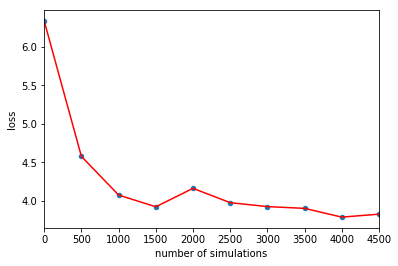

In [10]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()